In [ ]:
import pandas as pd 
import numpy as np

In [ ]:
# Load data
df = pd.read_csv('../data/inputs/NER2.csv')

In [ ]:
# Check the shape
print('NER', df.shape[0])
df

In [ ]:
# Updating column name
df.rename(columns = {'Unnamed: 0':'index'}, inplace = True)
df

In [ ]:
# Replacing null values (pages with no relevant named entities) with zeroes
df = df.fillna(0)
# Replacing any anomolous entries with 0
df = df.replace(r'^\s*$', 0, regex=True)
df

In [ ]:
# Make sure we have no duplicate nodes
max(df["url"].value_counts())

In [ ]:
# Changing the index
df.set_index('index')
df = df.drop(columns = ['url'])

In [ ]:
# Convert to numpy
x = df.to_numpy(dtype=np.compat.long)

In [ ]:
print(x.shape)
print(x)

In [ ]:
# Bringing in the node classification labels 
df_labels = pd.read_csv("../data/inputs/pages_ranked_with_data_labelled.csv")
# df_labels = df_labels[["page path", "label"]]
df_labels.head()

In [ ]:
# Need to have labels for each node (economic recovery or not economic recovery)
'''
In the form:

|| page_link   || relevant (y/n) ||
|| ------------||----------------||
|| page_link_0 ||        1       ||
|| page_link_1 ||        0       ||
|| page_link_2 ||        1       ||
...
'''
# Make sure we have no duplicate nodes
max(df_labels["url"].value_counts())

# Remove irrelevant columns
df_labels = df_labels.drop(columns=["url", "index"])

df_labels.shape[0]

# To numpy again... 
# y = df_labels.to_numpy(dtype=np.compat.long)
y = df_labels.label.tolist()
# print(y.shape)
print(y[0:5])

In [ ]:
# Creating train/val/test idx masks
# tm = pd.read_csv("../data/inputs/test_masks.csv")
# tm.head()

In [ ]:
# # Moving masks into lists
# train_mask = tm.index[0:100].tolist()
# val_mask = tm.index[100:224].tolist()
# test_mask = tm.index[224:].tolist()

In [ ]:
type(val_mask)

In [ ]:
# Now creating the edge df
df_edges = pd.read_csv("../edge_list.csv")
df_edges

In [ ]:
'''
Some pages were removed from the list prior to NER work
due to the page no longer existing or there being < 20 
characters in the page's text field.

It is now necessary to remove these nodes from the edge dataset,
as this was attained from N2V approach.
'''

# Creating a list of pages to be removed
pages_to_remove = [
    "/",
    "/search/all",
    "/find-covid-19-lateral-flow-test-site",
    "/guidance/coronavirus-covid-19-getting-tested",
    "/register-coronavirus-antibody-test",
    "/entering-staying-uk/foreign-nationals-working-in-uk",
    "/business-finance-support/business-cash-advance-uk",
    "/government/publications/applying-to-the-register-of-apprenticeship-training-providers-roatp",
    "/guidance/esfa-business-operations-help-and-support",
    "/business-finance-support/business-growth-calderdale",
    "/business-finance-support/low-carbon-workspaces-buckinghamshire",
    "/log-test-site-covid19-results",
    "/guidance/apprenticeships-resources-for-teachers-and-advisers",
    "/business-finance-support/south-east-creatives-seccads",
    "/business-finance-support/construction-industry-training-board-citb-grants-scheme-england",
    "/government/publications/turkey-list-of-lawyers/list-of-lawyers-in-ankara-and-gaziantep",
    "/business-finance-support/agri-tech-cornwall-cornwall-and-the-isles-of-scilly"
]

In [ ]:
# Removing pages from sources nodes
df_edges_1 = df_edges[~df_edges["source"].isin(pages_to_remove)]

In [ ]:
# Removing pages from target nodes
df_edges_2 = df_edges_1[~df_edges_1["target"].isin(pages_to_remove)]

In [ ]:
# Removing null rows
df_edges_3 = df_edges_2.dropna()

In [ ]:
# Now need to extract the edges
''' 
In the form:

[[0, 0, 0, 0, 0 , 0 , 0 , ...],
 [1, 5, 7, 9, 11, 14, 16, ...]]

Where this represents links existing between page 0 and 1, 5, 7, 9, 11, 14, 16...
'''

# gives df with edge weights (3 rows)
# want to use this later when get all working
# df_edges_3 = df_edges_3.drop(columns=["index", "source", "target"])

# gives df without edge weights (2 rows)
df_edges_4 = df_edges_3.drop(columns=["index", "source", "target", "edgeWeight"])


df_edges_4.shape[0]

In [ ]:
# Transposing and changing type
df_edges = df_edges_4.transpose()
df_edges = df_edges.astype(np.compat.long)
df_edges

In [ ]:
# To numpy again
z = df_edges.to_numpy(dtype=np.compat.long)
print(z.shape)
print(z[0:5])

In [ ]:
# Adding edge weight
df_weights = df_edges_3.drop(columns=["index", "source","target", "source_index", "target_index"])
print(df_weights.shape)
df_weights

In [ ]:
edge_attrs = df_weights.to_numpy(dtype=np.compat.long)
print(edge_attrs.shape)
print(edge_attrs[0:5])

# Creating pytorch-geometric dataset

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data

In [ ]:
# Defining the number of classes
# In this case 1 = relevant, 0 = not relevant
# Therefore, 2 classes
num_classes = 2

In [ ]:
# Converting np arrays to tensors
x = torch.Tensor(x)
y = torch.Tensor(y)
edge_index = torch.Tensor(z)
edge_attr = torch.Tensor(edge_attrs)
# train_mask = torch.Tensor(train_mask)
# val_mask = torch.Tensor(val_mask)
# test_mask = torch.Tensor(test_mask)
num_classes = torch.Tensor(num_classes)

In [ ]:
# Changing tensor type from float to long
# Uncomment for GCN
x = x.type(torch.LongTensor)
y = y.type(torch.LongTensor)
edge_index = edge_index.type(torch.LongTensor)
edge_attr = edge_attr.type(torch.LongTensor)
num_classes = num_classes.type(torch.LongTensor)

In [ ]:
# test_mask.type()

In [ ]:
# Creating pytorch-geometric dataset
dataset = Data(x = x, 
            edge_index=edge_index,
            y=y,
            edge_attr=edge_attr,
            # train_mask=train_mask,
            # val_mask=val_mask,
            # test_mask=test_mask,
            num_classes=num_classes)

In [ ]:
dataset.x
type(dataset.x)

In [ ]:
dataset.x = dataset.x.type(torch.long)
dataset.y = dataset.y.type(torch.long)
dataset.edge_index = dataset.edge_index.type(torch.long)
dataset.edge_attr = dataset.edge_index.type(torch.long)
dataset.num_classes = dataset.num_classes.type(torch.long)

In [ ]:
dataset.edge_index.dtype

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(pd.Series(list(x[:,0])), train_size=0.0472, shuffle=False)

In [ ]:
X_train, X_val = train_test_split(X_train, test_size=0.05, shuffle=True, random_state=123)

In [ ]:
train_mask = torch.zeros(10614, dtype=torch.bool)
val_mask = torch.zeros(10614, dtype=torch.bool)
test_mask = torch.zeros(10614, dtype=torch.bool)
train_mask[X_train.index] = True
val_mask[X_val.index] = True
test_mask[X_test.index] = True
dataset['train_mask'] = train_mask
dataset['val_mask'] = val_mask
dataset['test_mask'] = test_mask

In [ ]:
val_test = dataset.y[dataset.val_mask].type(torch.float64)
torch.mean(val_test)

In [ ]:
len(dataset.val_mask)

In [ ]:
dataset.y

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of edges: {dataset.num_edges}')
print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
print(f'Has self-loops: {dataset.has_self_loops()}')
# print(f'Is undirected: {dataset.is_undirected()}')
# print(f'Edge weight: {dataset.edge_weight}')

# Building out the GNN

https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

In [ ]:
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, GATConv

In [ ]:
# Creating GCN
from numpy import dtype
from torch import dropout


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1556, 32)
        self.conv2 = GCNConv(32, 2)

    def forward(self, data):
        
        x, edge_index = data.x.type(dtype=torch.float64), data.edge_index.type(dtype=torch.int64)#, data.edge_attr.type(dtype=torch.int64)
        # x, edge_index = data.x, data.edge_index

        # x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        x = F.leaky_relu(x)
        # x = F.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
from torch import dropout


device = torch.device('cpu')
model = GCN().to(device)
d = dataset.to(device)
# loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-5)

num_epochs = 750
model.train()
model = model.double()
loss_vals = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(d)
    loss = F.nll_loss(out[d.train_mask], d.y[d.train_mask])
    # loss = F.nll_loss(out[d.val_mask], d.y[d.val_mask])
    loss.backward()
    loss_vals.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    optimizer.step()

In [3032]:
model.eval()
pred = model(dataset).argmax(dim=1)
correct = (pred[dataset.val_mask] == dataset.y[dataset.val_mask]).sum()
acc = int(correct) / int(dataset.val_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7200


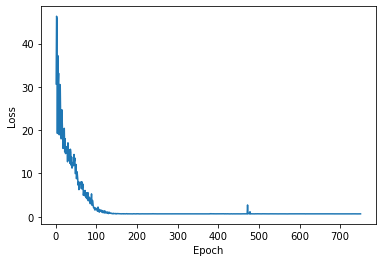

In [3033]:
import matplotlib.pyplot as plt
def my_plot(epochs, loss):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(epochs, loss)

my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)

In [3044]:
# Creating GAT
# TODO

from torch import LongTensor


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(42)
        self.gat1 = GATConv(1556, 16)
        self.gat2 = GATConv(16, 2) 

    def forward(self, d):
        x, edge_index = d.x.type(dtype=torch.float64), d.edge_index.type(dtype=torch.int64)#, data.edge_attr.type(dtype=torch.int64)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.gat2(x, edge_index)
        return x

# model = GAT(hidden_channels=8, heads=8)
print(model)

GCN(
  (conv1): GCNConv(1556, 32)
  (conv2): GCNConv(32, 2)
)


In [ ]:
device = torch.device('cpu')
model_GAT = GAT(hidden_channels=16, heads=16).to(device)
d = dataset.to(device)
# loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

num_epochs_GAT = 250
model_GAT.train()
model_GAT = model_GAT.double()
loss_vals_GAT = []
for epoch in range(num_epochs_GAT):
    optimizer.zero_grad()
    out = model_GAT(d)
    loss = F.cross_entropy(out[d.train_mask], d.y[d.train_mask])
    loss.backward()
    loss_vals_GAT.append(loss.detach().numpy())
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    optimizer.step()

In [3047]:
model_GAT.eval()
pred = model_GAT(dataset).argmax(dim=1)
correct = (pred[dataset.val_mask] == dataset.y[dataset.val_mask]).sum()
acc = int(correct) / int(dataset.val_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.2400


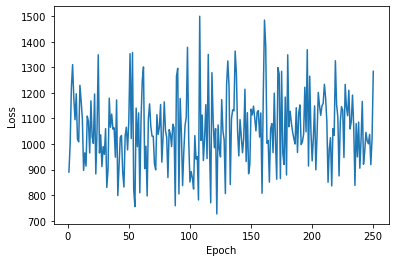

In [3048]:
my_plot(np.linspace(1, num_epochs_GAT, num_epochs_GAT).astype(int), loss_vals_GAT)

# Evaluation

In [ ]:
# This is the predictions of the validation set
prediction = pred[dataset.val_mask]
# This is the actual labels
truth = dataset.y[dataset.val_mask]

In [ ]:
print(prediction)
print(truth)

In [ ]:
def confusion(prediction, truth):
   """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

   confusion_vector = prediction / truth

   true_positives = torch.sum(confusion_vector == 1).item()
   false_positives = torch.sum(confusion_vector == float('inf')).item()
   true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
   false_negatives = torch.sum(confusion_vector == 0).item()

   return true_positives, false_positives, true_negatives, false_negatives


In [ ]:
TP, FP, TN, FN = confusion(prediction, truth)

In [ ]:
print("True positives:",TP)
print("False positives:",FP)
print("True negatives:",TN)
print("False negatives:",FN)